### 讲解如何自定义轴

In [7]:
# #### 比tick级别交易数据更细致的"队列交易数据"
#（Order Book Data或Market Depth Data）是指市场上尚未成交的买卖订单队列信息,
# 它提供了比成交数据更深入的市场微观结构洞察。后续见个人研学笔记。

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.tsa import stattools as ts
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import datetime


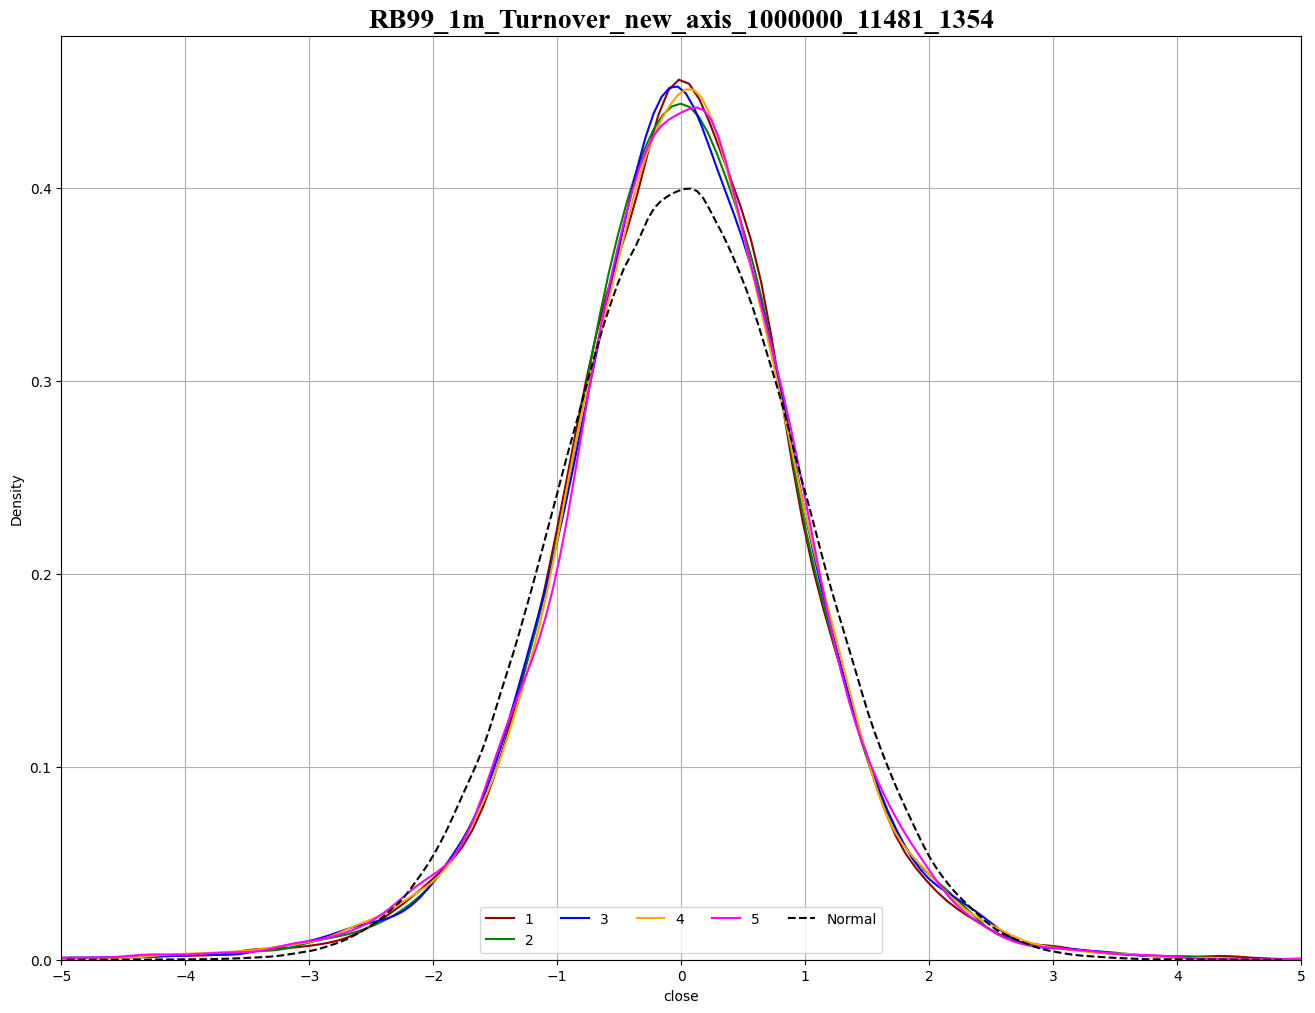

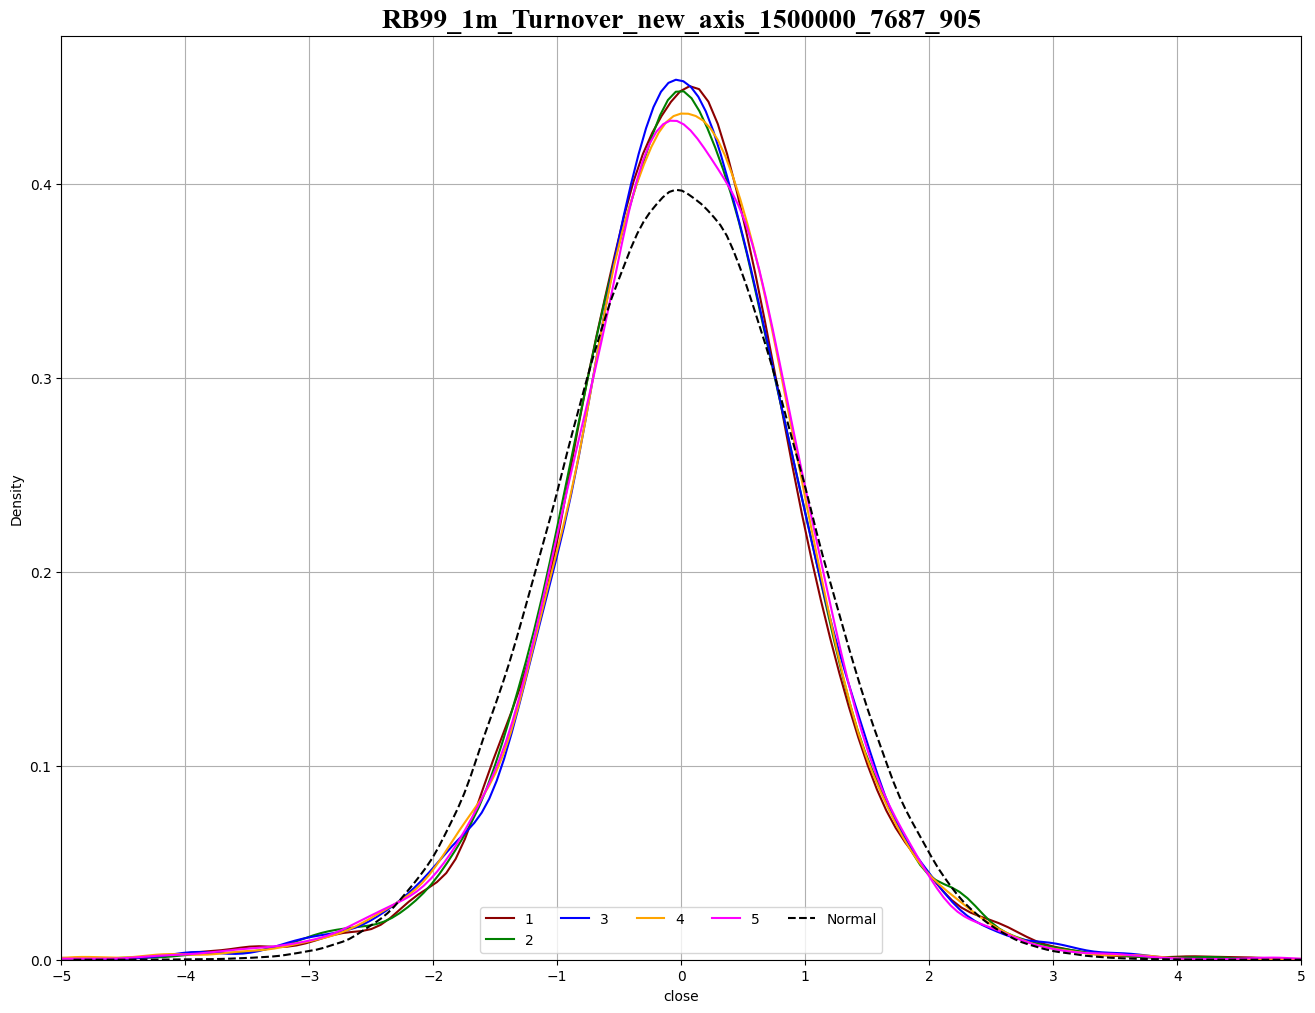

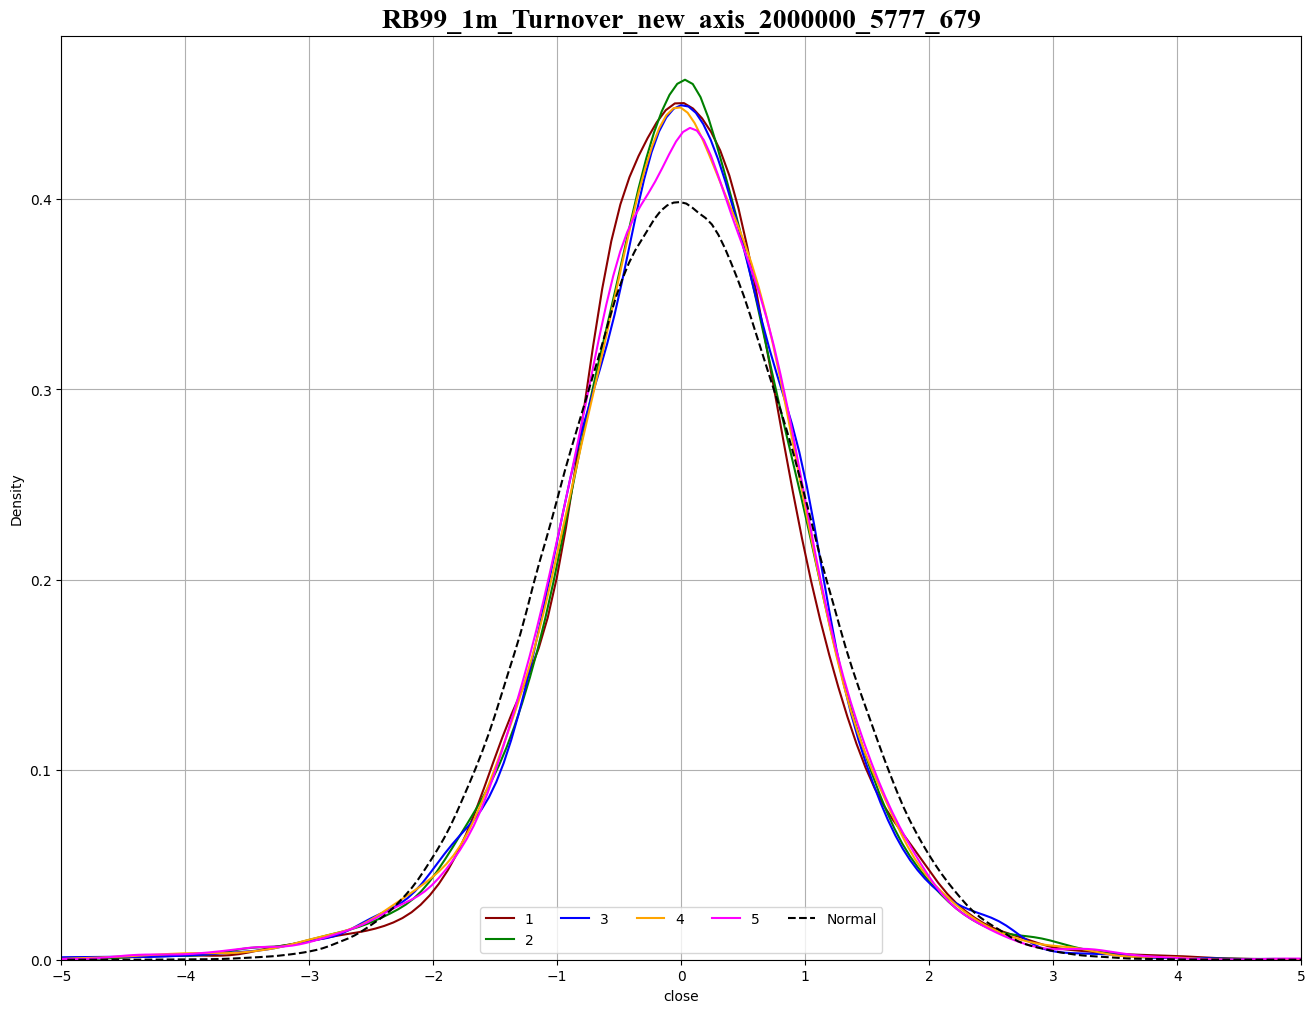

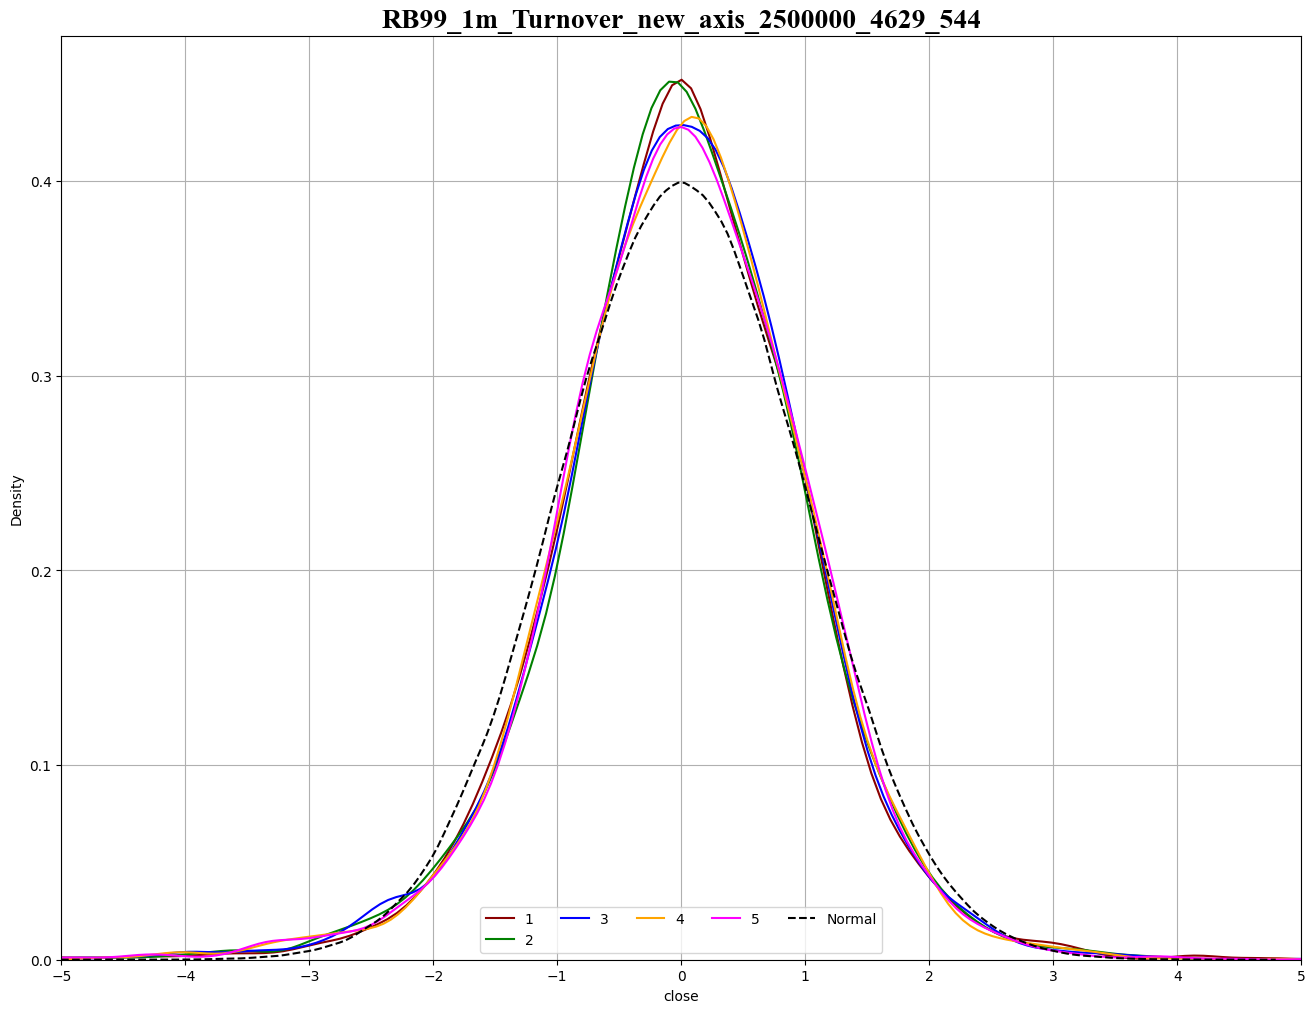

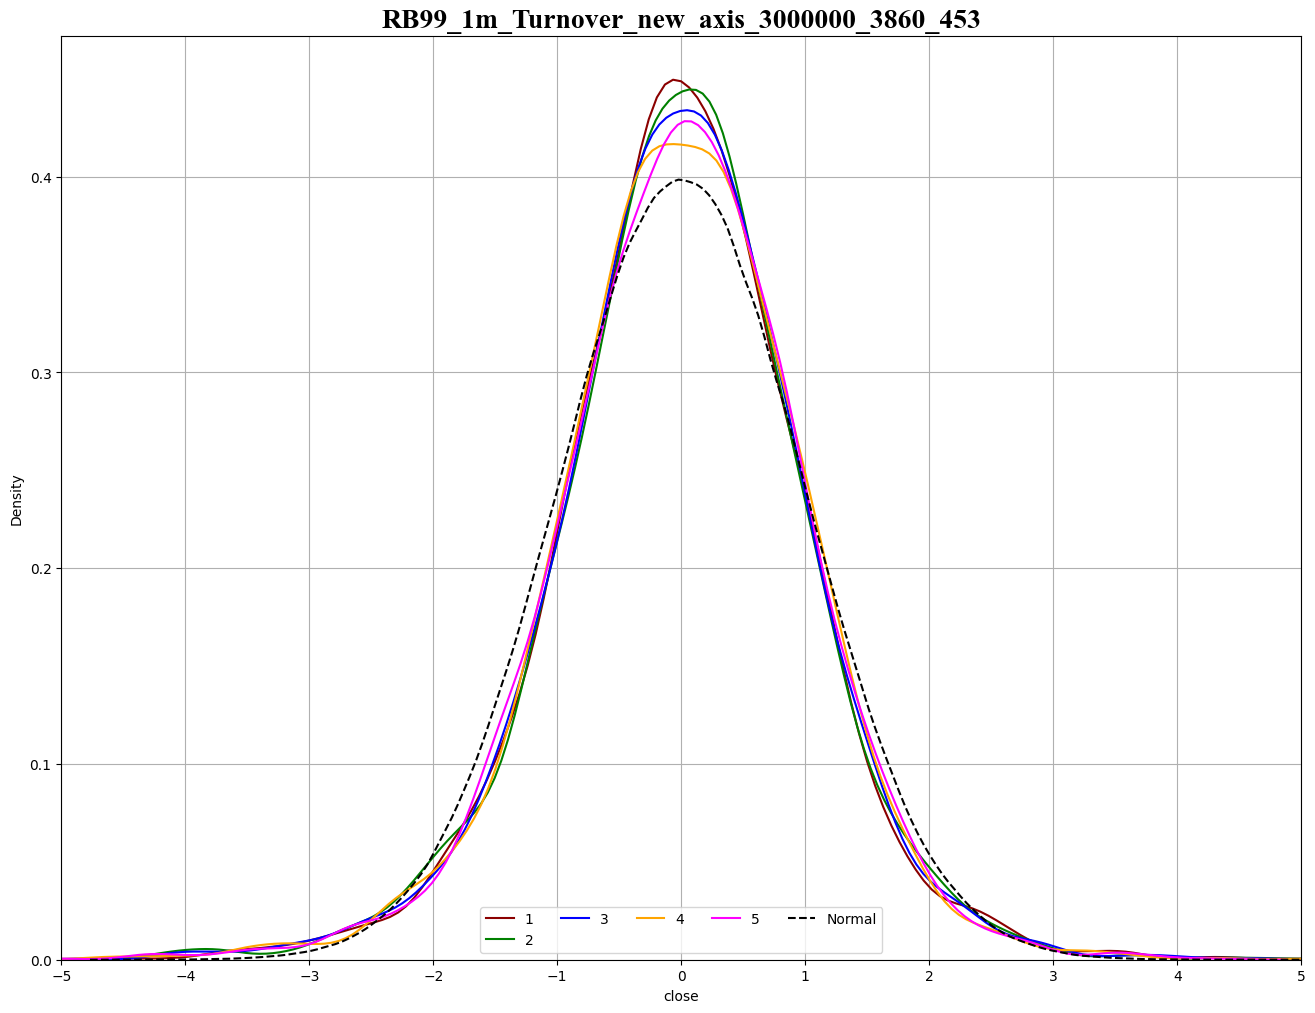

In [9]:
size = 1000000     ##############  初始成交额变化量 ，这个要根据标的特性自定义，主要依据成交量在本级别下的波动情况

add_size = 500000     ##############  每次累加的成交额变化量  ####################
# 这里有一个思路，如果有队列数据的话，可以以大单为单位，每次累加大单的成交额变化量，也即有效成交且带动价格的订单累计，生成新的bar。
# 轴不宜太复杂，越简单其实相对就好很多了，也可以用两个简单因子做组合，效果就很好了
baseline = "RB99_1m_Turnover_new_axis_"       ############### 保存文件的前缀 ##################


for j in range(5):        ############# 循环次数 ############   
    
    
    file_name ='RB99_1m_2010-01-05_2025-10-27.csv' ############原始数据文件
    df = pd.read_csv(file_name)


    buf_o = []
    buf_h = []
    buf_l = []
    buf_c = []
    buf_v = []
    buf_pos1 = []
    buf_pos2 = []
    res = []

    pos_sum = 0


    for i in range(0,len(df)):
        
        p_t = df['datetime'].iloc[i]
        p_o = df['open'].iloc[i]
        p_h = df['high'].iloc[i]
        p_l = df['low'].iloc[i]
        p_c = df['close'].iloc[i]
        p_v = df['volume'].iloc[i]
        p_tt = df['volume'].iloc[i]


        di = df.index.values[i]
###df.index.values 是一个数组,包含了DataFrame中所有行的索引值,通过 [i] 取出第i个位置的索引值,这个索引值通常是整数,表示当前行在DataFrame中的位置,可以用于后续的操作,比如根据索引值获取特定行的数据,或者进行索引操作。###
        buf_o.append(p_o)
        buf_h.append(p_h)
        buf_l.append(p_l)
        buf_c.append(p_c)
        buf_v.append(p_v)
        
        pos_sum = pos_sum + p_tt

        if pos_sum >= size:  # 如果 累计量 大于（初始成交额变化量） 时：生成一个bar
            o = buf_o[0]
            h = max(buf_h)
            l = min(buf_l)
            c = buf_c[-1]
            v = sum(buf_v)
            p = pos_sum

            

            res.append({
                'eob': p_t,
                'open': o,
                'high': h,
                'low': l,
                'close': c,  
                'volume': v,
                'pos': p,
                'hang':di
            })

            buf_o = [] # 清空缓存
            buf_h = [] # 清空缓存
            buf_l = [] # 清空缓存
            buf_c = [] # 清空缓存
            buf_v = [] # 清空缓存
            pos_sum = 0 # 重置累计量


    

    aaa = pd.DataFrame(res) #形成新的DataFrame表单
    date = aaa['eob'] > '2023-01-01'   # 测试集数量
    
    aaa.to_csv('./temp-成交量轴/' + baseline + str(size) + "_" + str(len(aaa)) + "_" +  str(len(aaa[date])) + ".csv",index = False)


    title_file = baseline + str(size) + "_" + str(len(aaa)) + "_" +  str(len(aaa[date]))
    # 这里的title_file 是为了后面的图片标题而设置的，因为图片标题中需要包含 成交额变化量阈值、新的bars数量、分割给测试集的数量 这三个信息。
    file_name1 = './temp-成交量轴/' + baseline + str(size) + "_" + str(len(aaa)) + "_" +  str(len(aaa[date])) + ".csv"
    # 读取新生成的bars数据,数据来自 file_name1 名字和aaa.csv的输出一样
    bars = pd.read_csv(file_name1)

    size = size + add_size   ######## 累加  ######


    bars.set_index("eob", inplace=True)

    returns_1 = np.log(bars['close']).diff().dropna()
    returns_2 = np.log(bars['close']).diff(periods=2).dropna()
    returns_3 = np.log(bars['close']).diff(periods=3).dropna()
    returns_4 = np.log(bars['close']).diff(periods=4).dropna()
    returns_5 = np.log(bars['close']).diff(periods=5).dropna()
    

    standard_1 = (returns_1 - returns_1.mean()) / returns_1.std()
    standard_2 = (returns_2 - returns_2.mean()) / returns_2.std()
    standard_3 = (returns_3 - returns_3.mean()) / returns_3.std()
    standard_4 = (returns_4 - returns_4.mean()) / returns_4.std()
    standard_5 = (returns_5 - returns_5.mean()) / returns_5.std()
    
 #绘图模块  
    plt.figure(figsize=(16,12))
    #设置图片标题中用到的中文
    # plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "Arial Unicode MS"]

    sns.kdeplot(standard_1, label="1", color='darkred')
    sns.kdeplot(standard_2, label="2", color='green')
    sns.kdeplot(standard_3, label="3", color='blue')
    sns.kdeplot(standard_4, label="4", color='orange')
    sns.kdeplot(standard_5, label="5", color='magenta')


    sns.kdeplot(np.random.normal(size=1000000), label="Normal", color='black', linestyle="--")

    plt.xticks(range(-5, 6))
    plt.legend(loc=8, ncol=5)
    plt.title(title_file,loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
    plt.xlim(-5, 5)
    plt.grid(1)
    plt.show()

    # plt.savefig(file_name1 + ".jpg")
    plt.savefig(f"{file_name1}_No{j+1}.jpg")  # 使用j+1确保编号从1开始
    plt.close()